In [1]:
pip install pandas


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install psycopg2

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.7 MB ? eta -:--:--
   --------------- ------------------------ 1.0/2.7 MB 3.1 MB/s eta 0:00:01
   --------------------------- ------------ 1.8/2.7 MB 3.2 MB/s eta 0:00:01
   ---------------------------------- ----- 2.4/2.7 MB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 3.1 MB/s eta 0:00:00


In [3]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import psycopg2
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv' , 'order_items')
]

# Connect to PostgreSQL database
conn = psycopg2.connect(
    host='localhost',
    user='postgres',
    password='Rifat2217?',
    dbname='ecommerce',
    port='5432'
)

cursor = conn.cursor()

# Folder containing CSV files
folder_path = 'E:/Project/Ecommerce'


# Function to map pandas dtype → PostgreSQL type
def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INTEGER'
    elif pd.api.types.is_float_dtype(dtype):
        return 'REAL'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'TIMESTAMP'
    else:
        return 'TEXT'


for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)

    # Read CSV
    df = pd.read_csv(file_path)

    # Replace NaN with None
    df = df.where(pd.notnull(df), None)

    print(f"Processing {csv_file}")
    print(f"NaN values:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [
        col.replace(' ', '_')
           .replace('-', '_')
           .replace('.', '_')
           .lower()
        for col in df.columns
    ]

    # CREATE TABLE query
    columns = ', '.join([
        f'"{col}" {get_sql_type(df[col].dtype)}'
        for col in df.columns
    ])

    create_table_query = f'''
        CREATE TABLE IF NOT EXISTS "{table_name}" (
            {columns}
        )
    '''

    cursor.execute(create_table_query)

    # INSERT data
    for _, row in df.iterrows():
        values = tuple(None if pd.isna(x) else x for x in row)

        sql = f'''
            INSERT INTO "{table_name}"
            ({', '.join([f'"{col}"' for col in df.columns])})
            VALUES ({', '.join(['%s'] * len(row))})
        '''

        cursor.execute(sql, values)

    conn.commit()

conn.close()


Processing customers.csv
NaN values:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_heig

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

db = psycopg2.connect(
    host="localhost",
    user="postgres",
    password="Rifat2217?",
    database="ecommerce"
)

cur = db.cursor()

In [39]:
#1. List all unique cities where customers are located.
query = """ select distinct customer_city from customers """

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns = ["City"])
df

,City
0,bom jardim de minas
1,alto rio doce
2,alvorada do gurgueia
3,batatais
4,capao da porteira
...,...
4114,carbonita
4115,concordia do para
4116,independencia
4117,governador valadares


In [40]:
#2. Count the number of orders placed in 2017.
query = """ 
select count(*)
from orders
where EXTRACT(YEAR FROM order_purchase_timestamp::DATE) =2017 """

cur.execute(query)
data = cur.fetchall()
"Total orders placed in 2017 are : ",data[0][0]

('Total orders placed in 2017 are : ', 90202)

In [5]:
#3. Find the total sales per category.
query = """ 
select 
	upper(products.product_category) as category,
	round(sum(payments.payment_value)::numeric,2) as sales
	from products
	join order_items
	on products.product_id = order_items.product_id
	join payments
	on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category","Sales"])
df

,Category,Sales
0,AGRO INDUSTRIA E COMERCIO,118731.00
1,ART,30992.90
2,ARTS AND CRAFTS,2326.17
3,AUDIO,60324.60
4,AUTOMOTIVE,852295.00
...,...,...
69,TECHNICAL BOOKS,24915.40
70,TELEPHONY,486883.00
71,TOYS,619038.00
72,WATCHES PRESENT,1429210.00


In [8]:
#4. Calculate the percentage of orders that were paid in installments.
query = """ 
select 
	round(
		sum(
		case 
			when payment_installments >=1 then 1
			else 0
		end
	)/count(*)::numeric*100,3
	)
from payments
"""

cur.execute(query)
data = cur.fetchall()
"The percentage of orders that were paid in installments is : " , data[0][0]

('The percentage of orders that were paid in installments is : ',
 Decimal('99.998'))

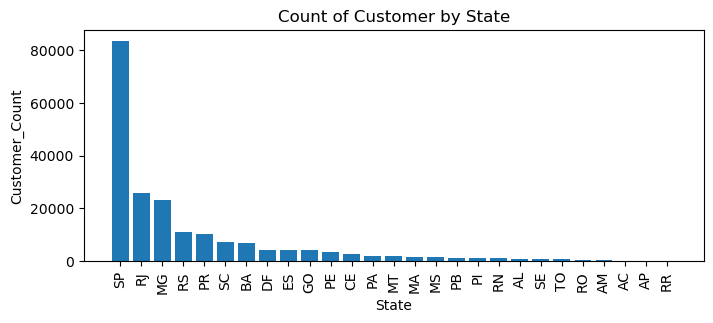

In [54]:
#5. Count the number of customers from each state. 
query = """ 
select
customer_state,
count(*) as total_customer
from customers
group by 1
"""

cur.execute(query)
data = cur.fetchall()
"The number of customers from each state is : "

df = pd.DataFrame(data,columns = ["State","Customer_count"])
df = df.sort_values(by = 'Customer_count', ascending = False)

plt.figure(figsize = (8,3))
plt.bar(df["State"],df["Customer_count"])
plt.xlabel("State")
plt.ylabel("Customer_Count")
plt.title("Count of Customer by State")
plt.xticks(rotation = 90)
plt.show()

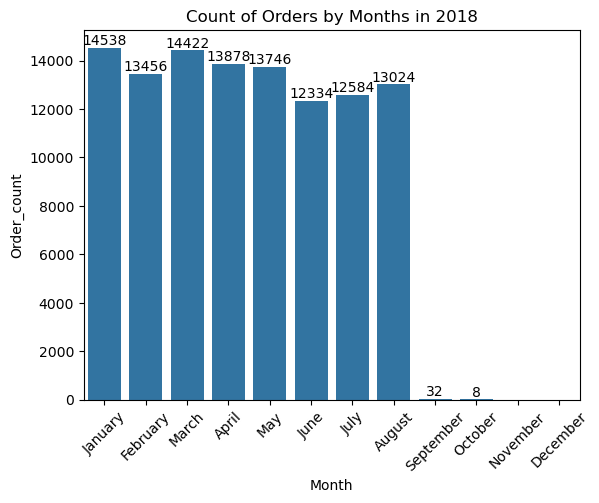

In [65]:
#6. Calculate the number of orders per month in 2018
query = """ 
select 
    to_char(order_purchase_timestamp::date, 'Month') as Months,
    count(*)
from orders
where extract(Year from order_purchase_timestamp::date) = 2018
group by Months
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns = ["Month","Order_count"])

df["Month"] = df["Month"].str.strip()
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
df["Month"] = pd.Categorical(df["Month"], categories=month_order, ordered=True)
df = df.sort_values("Month")

ax = sns.barplot(x=df["Month"], y=df["Order_count"])
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months in 2018")
plt.show()


In [70]:
#7. Find the average number of products per order, grouped by customer city
query = """ 
with count_per_order as 
(select 
	orders.order_id, 
	orders.customer_id, 
	count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select 
	customers.customer_city, 
	round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city 
order by average_orders desc
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head()

,customer city,average products/order
0,padre carvalho,14.00
1,celso ramos,13.00
2,candido godoi,12.00
3,datas,12.00
4,matias olimpio,10.00


In [73]:
#8. Calculate the percentage of total revenue contributed by each product category.
query = """ 
select 
	upper(products.product_category) category,
	round((sum(payments.payment_value::numeric)/(
												select sum(payment_value::numeric) 
												from payments))*100,2) sales_percentage
from products 
	join order_items 
	on products.product_id = order_items.product_id
	join payments 
	on payments.order_id = order_items.order_id
group by category 
order by sales_percentage desc
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "Percentage Distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


In [84]:
#9. Identify the correlation between product price and the number of times a product has been purchased.
import numpy as np
import pandas as pd

cur = db.cursor()

query = """
select 
    products.product_category, 
    count(order_items.product_id) as order_count,
    round(avg(order_items.price::numeric),2) as price
from products 
join order_items
on products.product_id = order_items.product_id
group by products.product_category
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category", "order_count", "price"])

# Convert to numeric properly
df["order_count"] = pd.to_numeric(df["order_count"])
df["price"] = pd.to_numeric(df["price"])

arr1 = df["order_count"].to_numpy()
arr2 = df["price"].to_numpy()

corr = np.corrcoef(arr1, arr2)[0,1]
print("The correlation is:", corr)



the correlation is -0.106316258238607


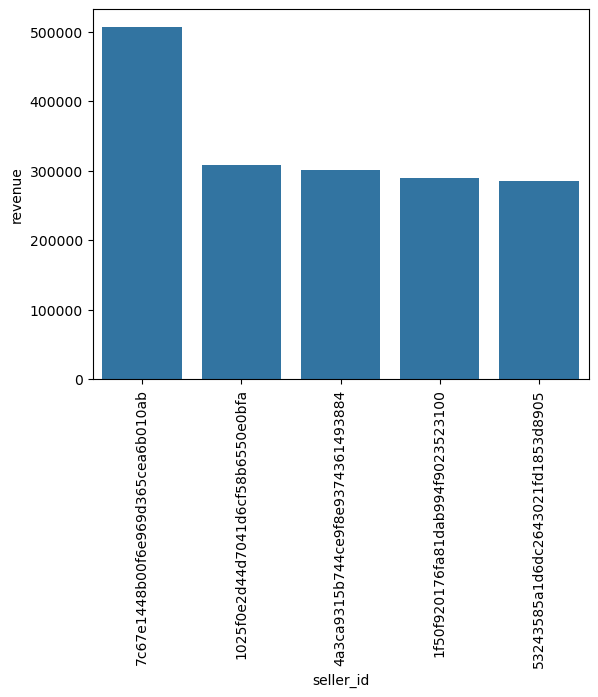

In [86]:
#10. Calculate the total revenue generated by each seller, and rank them by revenue
query = """ 
select 
	*, 
	dense_rank() over(order by revenue desc) as rn 
from (
		select 
			order_items.seller_id, 
			sum(payments.payment_value) revenue 
		from order_items 
		join payments
		on order_items.order_id = payments.order_id
		group by order_items.seller_id)
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

In [93]:
#11. Calculate the moving average of order values for each customer over their order history.
query = """
select 
	customer_id, 
	order_purchase_timestamp, 
	payment,
	avg(payment) over(partition by customer_id order by order_purchase_timestamp
		rows between 2 preceding and current row) as mov_avg
from
(select 
	orders.customer_id, 
	orders.order_purchase_timestamp, 
	payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id)
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Customer Id", "Order_purchase_timestamp", "payment","Mov_Agg"])
df

,Customer Id,Order_purchase_timestamp,payment,Mov_Agg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
...,...,...,...,...
207767,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
207768,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207769,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207770,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


In [91]:
#12. Calculate the cumulative sales per month for each year.
query = """
select 
	years, 
	months , 
	payment, 
	sum(payment) over(order by years, months) cumulative_sales 
from (select 
		extract(year from orders.order_purchase_timestamp::date) as years,
		extract(month from orders.order_purchase_timestamp::date) as months,
		round(sum(payments.payment_value::numeric),2) as payment 
	from orders join payments
	on orders.order_id = payments.order_id
	group by years, 
	months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Year", "Months", "Payment","Cumulative_Sales"])
df

,Year,Months,Payment,Cumulative_Sales
0,2016,9,504.48,504.48
1,2016,10,118180.96,118685.44
2,2016,12,39.24,118724.68
3,2017,1,276976.08,395700.76
4,2017,2,583816.02,979516.78
5,2017,3,899727.20,1879243.98
6,2017,4,835576.06,2714820.04
7,2017,5,1185837.64,3900657.68
8,2017,6,1022552.76,4923210.44
9,2017,7,1184765.84,6107976.28


In [94]:
#13. Calculate the year-over-year growth rate of total sales.
query = """
with a 
as
(select 
	extract(year from orders.order_purchase_timestamp::date) as years,
	round(sum(payments.payment_value::numeric),2) as payment 
from orders join payments
on orders.order_id = payments.order_id
group by years 
order by years
)

select 
	years, 
	((payment - lag(payment, 1) over(order by years))/lag(payment, 1) over(order by years)) * 100 
from a
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "YoY % Growth"])
df

,years,yoy % growth
0,2016,None
1,2017,12112.7037950323386800
2,2018,20.00092348053399244600


In [96]:
#14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase 
#within 6 months of their first purchase.
query = """
with a 
as 
(
select 
	customers.customer_id,
	min(orders.order_purchase_timestamp::date) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id
),

b as 
(
select 
	a.customer_id, 
	count(distinct orders.order_purchase_timestamp::date) next_order
from a join orders
on orders.customer_id = a.customer_id
where	orders.order_purchase_timestamp::date > first_order
	    and orders.order_purchase_timestamp::date < first_order + INTERVAL '6 months'
group by a.customer_id
) 

select 
	100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id
"""

cur.execute(query)
data = cur.fetchall()

data


InFailedSqlTransaction: current transaction is aborted, commands ignored until end of transaction block


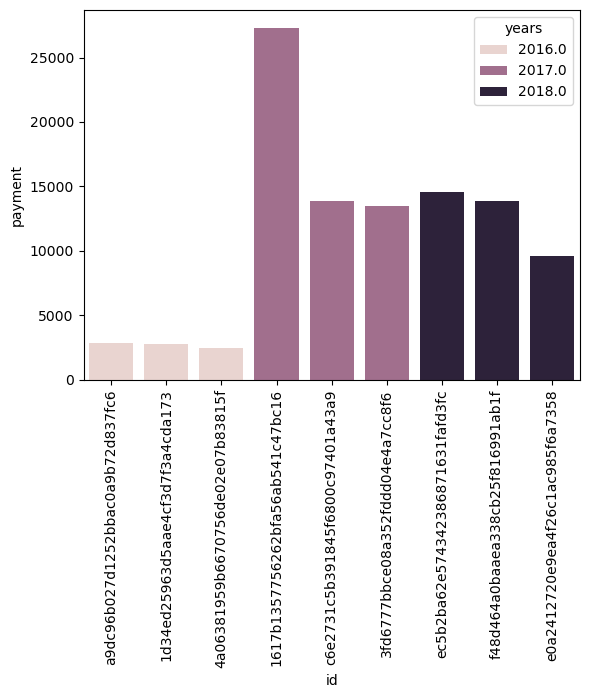

In [99]:
#15. Identify the top 3 customers who spent the most money in each year.
query = """
select 
years, 
customer_id, 
payment, r_rank
from (
		select 
			extract(year from orders.order_purchase_timestamp::date) years,
			orders.customer_id,
			sum(payments.payment_value::numeric) payment,
			dense_rank() over(partition by extract(year from orders.order_purchase_timestamp::date)
				order by sum(payments.payment_value::numeric) desc) r_rank
		from 
		orders join payments 
		on payments.order_id = orders.order_id
		group by extract(year from orders.order_purchase_timestamp::date),orders.customer_id
	) as a
where r_rank <= 3 
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()